In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.nn import CrossEntropyLoss

import os
import pandas
import numpy as np
import idx2numpy

from typing import Tuple

import matplotlib.pyplot as plt

# Hyper Parameter selection

- you know this notebook already: it is the Notebook Nb2.C
- Here we have implemented a small conv net to train on MNIST
- What we have not done so far is to do a proper hyper parameter search
- this will be the goal now

## TODO

Adapt the notebook in the following way:
- Currently there is no validation function - add it!
- The main function should have as arguments: learning_rate, batch_size, activation_function
- Crate a grid search over this paramters
- This means: create three lists eg: learning_rates = [0.1, 0.01, 0.001], batch_size = [8, 16, 32], activation_functions = [ReLu, Elu]
- iterate over all combinations of the above values: i.e. for the above case this means you need to train 3x3x2 models 
- in the best case you train models with the same hyper parameter settings multiple times, each with different seed - but this is not necessary here
- Track the learning curves of: train loss, val loss, train accuracy, val accuracy
- based on the curves: choose a model that you think is best!
        

In [3]:
#! pip install idx2numpy

In [4]:
# A[1]
# TODO: addapt the model such that the activation function is a parameter!

class CNN(nn.Module):
    #def __init__(self, activationFirst, activationSecond): tried with multiple Activation funcs
    def __init__(self, activationFunc):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(in_channels=1,
                      out_channels=16,            
                      kernel_size=5,              
                      stride=1,                   
                      padding=2),                              
            activationFunc,                      
            nn.MaxPool2d(kernel_size=2)   
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            activationFunc,                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
        self.is_conv = True
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output 
            
    
    def zero_init(self):
        for p in self.parameters():
            p.data.zero_()

In [5]:
def load_idxfile(path: str) -> np.array:
    # can we do that for all files in the folder? 
    arr = idx2numpy.convert_from_file(path)
    return arr

In [6]:
# TODO: addapt the paths and load the files
# file_path = r'/home/hubert/Lecture/data/raw/t10k-images.idx3-ubyte'

notebook_path = os.path.abspath("A4.ipynb")
folder = os.path.join(os.path.dirname(notebook_path), "idx_raw")

file_path = os.path.join(folder, "t10k-images.idx3-ubyte")
data = load_idxfile(file_path)
file_path_labels = os.path.join(folder, "t10k-labels.idx1-ubyte")
labels = load_idxfile(file_path_labels)

In [7]:
# Definition of the data set: Nothing to do here
class MNISTDset(Dataset):
    def __init__(self, images: np.array, labels: np.array) -> None:
        self.images = torch.tensor(images)/255.
        self.labels = torch.tensor(labels)
        self.num_samples = len(self.labels)
        
        # nomralize to standard deviation
        self._normalize()
        
        
    def set_num_samples(self, n:int=None) -> None:
        '''
        Restrict numbers of samples. 
        Not necessary, but sometimes useful for model testing 
        '''
        if n is None:
            self.num_samples = len(self.labels)
        else:
            assert 0 <=  n <= len(self.labels)
            self.num_samples = n
            
    def _normalize(self, mean: float=None, std: float=None):
        if std is not None: 
            assert std > 0
        '''Normalize data to nomral standard'''
        self.images = self.images - self.images.mean() if mean is None else self.images - mean 
        self.images = self.images / (self.images.std() + 1e-12) if std == None else self.images / std
        
    def __len__(self):
        ret = self.num_samples
        return ret
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor, int]:
        image = self.images[idx]
        label = self.labels[idx]
        return image, label, idx 

In [8]:
def accuracy(out, labels):
    return (out.argmax(-1) == label).float()

In [9]:
# A[2]
# TODO: addapt the function such that you can track the train loss and train accuracy
# -> adjusted return to be Tuple[float,float]
def train(model, train_loader, optimizer, loss_fun, device, epoch) -> Tuple[float, float]:
    model.train()
    
    n_batches = len(train_loader)
    for i, (image, targets, idx) in enumerate(train_loader):
        # get batch size
        bs = image.shape[0]
            
        # fully connected model: we need to flatten the images
        x = image.view(bs,-1) if not model.is_conv else image.view(bs,1,28,28)
            
        # image to device
        x = x.to(device)
            
        # zero grads
        optimizer.zero_grad()
            
        # forward pass
        out = model(x)
            
        # calc loss and gradients
        loss = loss_fun(out, targets).mean()
        loss.backward()
            
        # update
        optimizer.step()
    return loss.item()

In [10]:
# A[3]:
# TODO: write the eval function - make sure you can track the eval loss and the eval accuracy!

# Eric: I suppose the valid Method is meant

def valid(model, train_loader, optimizer, loss_fun, device, epoch) -> Tuple[float, float]:
    # TODO: adapt code beolow
    model.train()
    
    n_batches = len(train_loader)
    for i, (image, targets, idx) in enumerate(train_loader):
        # get batch size
        bs = image.shape[0]
            
        # fully connected model: we need to flatten the images
        x = image.view(bs,-1) if not model.is_conv else image.view(bs,1,28,28)
            
        # image to device
        x = x.to(device)
            
        # zero grads
        optimizer.zero_grad()
            
        # forward pass
        out = model(x)
            
        # calc loss and gradients
        loss = loss_fun(out, targets).mean()
        loss.backward()
            
        # update
        optimizer.step()
    return loss.item()

In [16]:
# A[4]: Choose a reasonable split (i.e. size of the splits)
# Justify your choice!
# we split the data into train and validation dataset and create two dataloader objects

# its common to use a 80/20% split for train and validation data size - this
# was recommanded to us by lecturers.
dataCount = len(data)
print("data count=", dataCount)

dataTrainCount = (int) (dataCount * 0.8)
print("80% train data split count =", dataTrainCount)

# training data
train_data = data[:dataTrainCount] # this will take a subset of the data till the 80% size of the numpy array
train_labels = labels[:dataTrainCount] # same for labels
train_dset = MNISTDset(images=train_data, labels=train_labels)
train_loader = DataLoader(dataset=train_dset, batch_size=8, shuffle=True, num_workers=0)

print("actual train_data count =", train_data.size)
print("actual train_labels count =", train_labels.size)

# val data
val_data = data[dataTrainCount:] # takes the last 20% of the numpy array as validation set
val_labels = labels[dataTrainCount:] # same for labels
val_dset = MNISTDset(images=val_data, labels=val_labels)
val_loader = DataLoader(dataset=val_dset, batch_size=8, shuffle=False, num_workers=0)

print("actual val_data count=", val_data.size)
print("actual val_labels count =", val_labels.size)

data count= 10000
80% train data split count = 8000
actual train_data count = 6272000
actual train_labels count = 8000
actual val_data count= 1568000
actual val_labels count = 2000


In [31]:
# A[5]-A[10]: 
# - Adapt the main loop like described above: it should have three arguments: learning rates, batch size and activation functions 
# - iterate over all combinations of the hyper parameters 
# - init everything that is necessary to train the model and: train a model for each combination
# - track the learning curves for all combinations - the main function should return the all learning curves for all combinations 
# - plot all learning curves for every trained model and choose the one you think is best
# - justify your choice
# implement main loop 
from audioop import avg


def main( learning_rates:list, batch_sizes:list, activation_functions:list):
    num_epochs = 20
    bestModel = None
    bestAcc = 0
    for activFunc in activation_functions:
        for batchSize in batch_sizes:
            for learningRate in learning_rates:                
                model = CNN(activFunc)
                model.zero_init()
                print(model)
                optimizer = optim.Adam(params=model.parameters(),lr=learningRate)
                ce_loss = CrossEntropyLoss()

                device = 'cpu'
                model = model.to(device)

                tr_loss = []
                tr_acc = []
                ev_loss = []
                ev_acc = []
                for epoch in range(num_epochs):
                    loss = train(model, train_loader, optimizer, ce_loss, device, epoch)
                    tr_loss.append(loss)


                    # calculate accuracy
                    model.eval()
                    N = batchSize
                    x, label, idx = train_dset[:N] 
                    x = x.view(N,1,28,28) if model.is_conv else  x.view(N,-1) 
                    out = model(x)
                    acc_ = (out.argmax(-1) == label).float().sum()/len(label)
                    tr_acc.append(acc_)


                    x, label, idx = val_dset[:N] 
                    x = x.view(N,1,28,28) if model.is_conv else  x.view(N,-1)
                    model.eval()
                    out = model(x)
                    acc_ = (out.argmax(-1) == label).float().sum()/len(label)
                    ev_acc.append(acc_)


                    print(f'epoch [{epoch+1}/{num_epochs}]: train loss = {loss:.5f}, train acc = {tr_acc[-1]:.5f}, val acc = {ev_acc[-1]:.5f}')

                plt.plot(tr_loss, label='train loss')
                plt.legend()
                plt.show()

                plt.plot(tr_acc, label='train accuracy')
                plt.plot(ev_acc, label='eval accuracy')
                
                hihgest_acc = sum(ev_acc) / len(ev_acc)
                # remember best model
                if(hihgest_acc > bestAcc):
                    print(f'this Model is better than best so far. Old eval acc: {bestAcc}, this eval acc: {ev_acc}')
                    bestAcc = hihgest_acc
                    bestModel = model
                
                plt.title('acc')
                plt.legend()
                plt.show()
    return bestModel

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.28064, train acc = 0.00000, val acc = 0.00000
epoch [2/20]: train loss = 2.32396, train acc = 0.00000, val acc = 0.00000
epoch [3/20]: train loss = 2.14978, train acc = 0.25000, val acc = 0.25000
epoch [4/20]: train loss = 2.41414, train acc = 0.12500, val acc = 0.00000
epoch [5/20]: train loss = 2.41292, train acc = 0.00000, val acc = 0.00000
epoch [6/20]: train loss = 2.38000, train acc = 0.25000, val acc = 0.25000
epoch [7/20]: train loss = 2.31529, train acc = 0.25000, val acc = 0.25000
epo

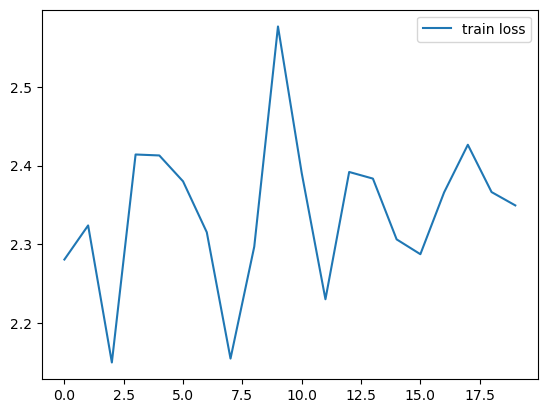

this Model is better than best so far. Old eval acc: 0, this eval acc: [tensor(0.), tensor(0.), tensor(0.2500), tensor(0.), tensor(0.), tensor(0.2500), tensor(0.2500), tensor(0.), tensor(0.), tensor(0.2500), tensor(0.1250), tensor(0.), tensor(0.2500), tensor(0.1250), tensor(0.2500), tensor(0.), tensor(0.2500), tensor(0.3750), tensor(0.), tensor(0.1250)]


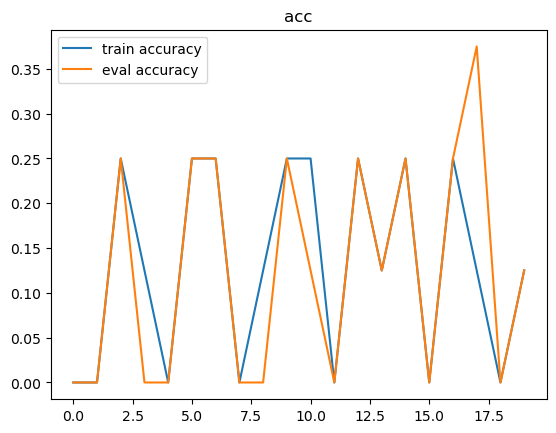

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
epoch [1/20]: train loss = 2.24434, train acc = 0.12500, val acc = 0.12500
epoch [2/20]: train loss = 2.28791, train acc = 0.25000, val acc = 0.25000
epoch [3/20]: train loss = 2.28462, train acc = 0.25000, val acc = 0.25000
epoch [4/20]: train loss = 2.30540, train acc = 0.12500, val acc = 0.00000
epoch [5/20]: train loss = 2.31832, train acc = 0.12500, val acc = 0.37500
epoch [6/20]: train loss = 2.24871, train acc = 0.25000, val acc = 0.25000
epoch [7/20]: train loss = 2.31889, train acc = 0.12500, val acc = 0.37500
epo

In [32]:
learning_rates = [0.1, 0.01, 0.001] 
batch_size = [8, 16, 32]
activation_functions = [nn.ReLU(), nn.ELU()]

model = main(learning_rates, batch_size, activation_functions)